# Testing Object Detection with VinVL

1. Import `mlmodule` modules

In [1]:
from mlmodule.torch.options import TorchRunnerOptions
from mlmodule.torch.runners import TorchInferenceRunner
from mlmodule.callbacks.memory import (
    CollectBoundingBoxesInMemory,
)
from mlmodule.helpers.files import list_files_in_dir
from mlmodule.torch.datasets import (
    LocalBinaryFilesDataset,
    ImageDataset
)
from mlmodule.models.vinvl.pretrained import torch_vinvl_detector

import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import os
%matplotlib inline

/home/lebret/projects/mlmodule/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Load images

In [2]:
base_path = os.path.join("../tests", "fixtures", "objects")
file_names = list_files_in_dir(base_path, allowed_extensions=('jpg',))[:50]
dataset = ImageDataset(LocalBinaryFilesDataset(file_names))

3. Run object detection with `torch_vinvl_detector`

In [3]:
# Load VinVL model (it might take a few minutes.)
torch_device = torch.device("cuda")
vinvl = torch_vinvl_detector(device=torch_device, score_threshold=0.5)

bb = CollectBoundingBoxesInMemory()

# Runner
runner = TorchInferenceRunner(
    model=vinvl,
    dataset=dataset,
    callbacks=[bb],
    options=TorchRunnerOptions(
        device=torch_device, 
        data_loader_options={"batch_size": 10},
        tqdm_enabled=True
    ),
)
runner.run()

100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


4. Visualise the detected objects

First get labels and attributes

Object detected for ../tests/fixtures/objects/soldiers.jpg
Object detected for ../tests/fixtures/objects/icrc_vehicle.jpg


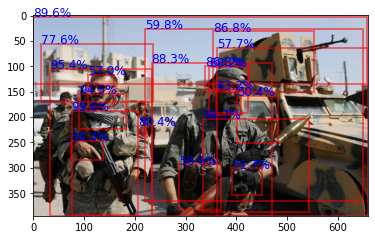

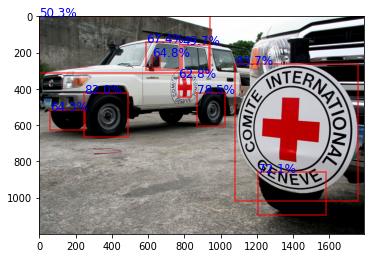

In [13]:
for i, img_path in enumerate(bb.indices):
    print(f'Object detected for {img_path}')
    img = Image.open(img_path).convert('RGB')
    plt.figure()
    plt.imshow(img)
    bboxes = bb.bounding_boxes[i].bounding_boxes
    scores = bb.bounding_boxes[i].scores
    for k, bbox in enumerate(bboxes):
        bbox0, bbox1, bbox2, bbox3 = bbox
        plt.gca().add_patch(Rectangle((bbox0, bbox1),
                                        bbox2 - bbox0,
                                        bbox3 - bbox1, fill=False,
                                      edgecolor='red', linewidth=2, alpha=0.5))
        plt.text(
            bbox0, bbox1, f'{scores[k]*100:.1f}%', color='blue', fontsize=12)
